In [3]:
from pybaselines import Baseline, utils
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt


Current data is shaped: (1250, 100, 514)


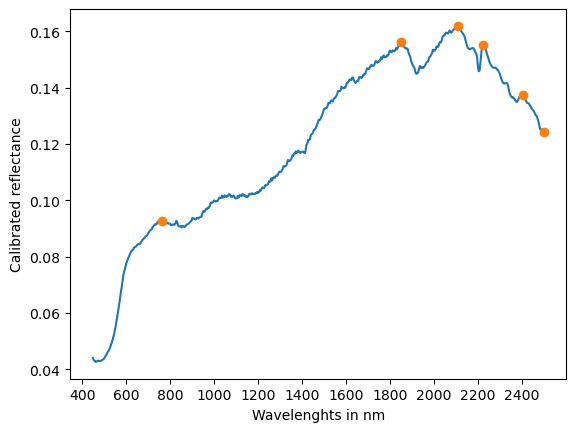

In [63]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 490
curr_y = 54

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')
plt.xticks(np.arange(400,2500, step = 200))

# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel,
                   width = 5)[0]
# Append the end of the spectrum
peaks = np.append(peaks, curr_pixel.shape[0]-1)

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

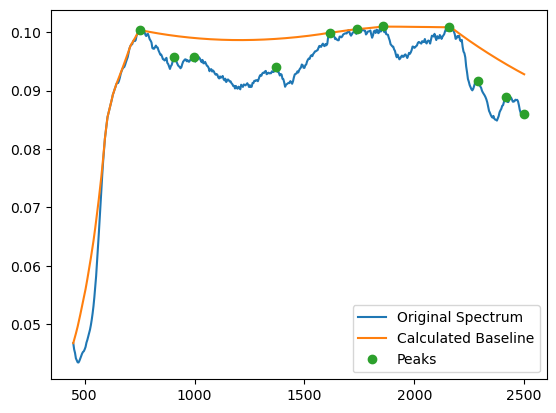

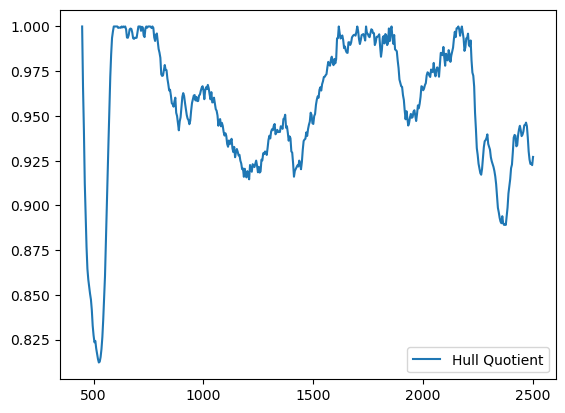

In [10]:
baseline_fitter = Baseline(wav_array,
                           check_finite=False)

# Invert the data 
pix_inverse = 1 / curr_pixel 

# Calculate the baseline
baseline_inv = baseline_fitter.snip(pix_inverse,
                             max_half_window=40,
                             decreasing=True,
                             smooth_half_window=0)[0]

# Invert the result
curr_baseline = 1 / baseline_inv         

plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, curr_baseline, label='Calculated Baseline')
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
plt.legend()

# plt.figure()
# plt.plot(wav_array, curr_pixel-curr_baseline, label='Hull difference')
# plt.legend()

plt.figure()
plt.plot(wav_array, curr_pixel/curr_baseline, label='Hull Quotient')
plt.legend()


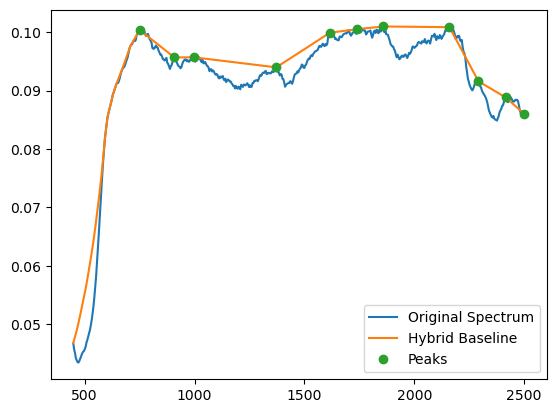

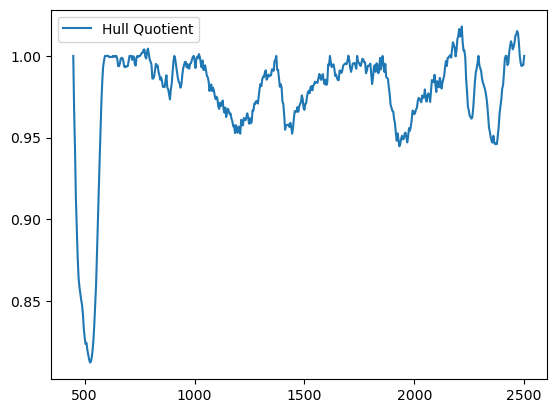

In [11]:
# Interpolate linearly to get the lower hull
def interpolate_linear(spectrum, indices):
    # Create an interpolation function based on the given indices
    interp_func = interp1d(indices,
                           spectrum[indices],
                           fill_value="extrapolate")
    # Apply the interpolation function to the entire range of indices
    lower_hull = interp_func(np.arange(len(spectrum)))
    return lower_hull


prelim_hull = interpolate_linear(curr_pixel[peaks[0]:],
                                 peaks - peaks[0])

concat_hull = np.concatenate((curr_baseline[0:peaks[0]],
                              prelim_hull))

plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, concat_hull, label='Hybrid Baseline')
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
plt.legend()

plt.figure()
plt.plot(wav_array, curr_pixel/concat_hull, label='Hull Quotient')
plt.legend()


In [38]:
# make a new array to store the hull removed pixels in

baseline_corrected_array = np.empty_like(curr_data_array)

# Build an ugly loop for this for now, parallelize later

# Set the pixel we want for now
for curr_x in range(curr_data_array.shape[0]):
    for curr_y in range(curr_data_array.shape[1]):
        # Get the current pixel
        curr_pixel = curr_data_array[curr_x,
                                     curr_y,
                                     :]
        # Get the peaks of the current spectrum
        peaks = find_peaks(curr_pixel, width = 5)[0]
        # Append the end of the spectrum
        peaks = np.append(peaks,
                          curr_pixel.shape[0]-1)
        
        # Initialize the fitter
        baseline_fitter = Baseline(wav_array,
                           check_finite=False)
        # Invert the data 
        pix_inverse = 1 / curr_pixel 
        # Calculate the baseline
        baseline_inv = baseline_fitter.snip(pix_inverse,
                                     max_half_window=40,
                                     decreasing=True,
                                     smooth_half_window=0)[0]

        # Invert the result
        curr_baseline = 1 / baseline_inv
        # Store the hull quotient
        baseline_corrected_array[curr_x,
                                 curr_y,
                                 :] = curr_pixel / curr_baseline

In [56]:
import pickle
# open a file
file = open('baseline_corrected_array.pickle', 'wb')
pickle.dump(baseline_corrected_array, file)
file.close()

In [12]:
# Interpolate linearly to get the lower hull
def interpolate_linear(spectrum, indices):
    # Create an interpolation function based on the given indices
    interp_func = interp1d(indices,
                           spectrum[indices],
                           fill_value="extrapolate")
    # Apply the interpolation function to the entire range of indices
    lower_hull = interp_func(np.arange(len(spectrum)))
    return lower_hull

# make a new array to store the hull removed pixels in

baseline_hybrid_corrected_array = np.empty_like(curr_data_array)

# Build an ugly loop for this for now, parallelize later

# Set the pixel we want for now
for curr_x in range(curr_data_array.shape[0]):
    for curr_y in range(curr_data_array.shape[1]):
        # Get the current pixel
        curr_pixel = curr_data_array[curr_x,
                                     curr_y,
                                     :]
        # Get the peaks of the current spectrum
        peaks = find_peaks(curr_pixel, width = 5)[0]
        # Append the end of the spectrum
        peaks = np.append(peaks,
                          curr_pixel.shape[0]-1)
        
        # Initialize the fitter
        baseline_fitter = Baseline(wav_array,
                           check_finite=False)
        # Invert the data 
        pix_inverse = 1 / curr_pixel 
        # Calculate the baseline
        baseline_inv = baseline_fitter.snip(pix_inverse,
                                     max_half_window=40,
                                     decreasing=True,
                                     smooth_half_window=0)[0]

        # Invert the result
        curr_baseline = 1 / baseline_inv

        prelim_hull = interpolate_linear(curr_pixel[peaks[0]:],
                                 peaks - peaks[0])

        concat_hull = np.concatenate((curr_baseline[0:peaks[0]],
                                      prelim_hull))

        
        # Store the hull quotient
        baseline_hybrid_corrected_array[curr_x,
                                        curr_y,
                                        :] = curr_pixel / concat_hull

In [15]:
import pickle
# open a file
file = open('baseline_hybrid_corrected_array.pickle', 'wb')
pickle.dump(baseline_hybrid_corrected_array, file)
file.close()